In [2]:
import json
import matplotlib.pyplot as plt
import os
import random
import sys
import torch
import torch.nn as nn
from monai.metrics import DiceMetric
from omegaconf import OmegaConf
from torch.utils.data import DataLoader

REPO_PATH = '/workspace/repositories/DSSQ/src'
OUT_PATH = '/workspace/out'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
sys.path.append(REPO_PATH)

from adapters import DimReductAdapter, DimReductModuleWrapper
from data_utils import get_eval_data
from models import get_unet
from utils import epoch_average

In [11]:
# Set mode
MODE = 'eval'
LOG = False
ITERATION = 0
DATA_KEY = 'prostate'
LOAD_ONLY_PRESENT = True
VALIDATION = True
EXTRA_DESCRIPTION = '_base'
N_DIMS = [2, 4]

cfg = OmegaConf.load(f'{REPO_PATH}/configs/conf.yaml')
OmegaConf.update(cfg, 'run.iteration', ITERATION)
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)

# unet_name = 'swinunetr'
unet_name = 'monai-64-4-4'
args = unet_name.split('-')
cfg.wandb.log = LOG
cfg.unet[DATA_KEY].pre = unet_name
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = None if unet_name == 'swinunetr' else int(args[1])
cfg.unet[DATA_KEY].training.load_only_present = LOAD_ONLY_PRESENT
cfg.unet[DATA_KEY].training.validation = VALIDATION
cfg.unet[DATA_KEY].training.batch_size = 32
cfg.wandb.project = f'{DATA_KEY}_{unet_name}_{ITERATION}{EXTRA_DESCRIPTION}'
if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])
# Set cfg.format to "numpy" for evaluation,
# otherwise don't modify it or set to "torch" for training
if MODE == 'eval': cfg.format = 'numpy'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if unet_name != 'swinunetr': layer_names = [f'model.{"1.submodule." * i}0.conv' for i in range(cfg.unet[DATA_KEY].depth)]
train_vendors = ['siemens']
test_vendors = ['siemens', 'philips', 'ge']
dim_red_modes = ['IPCA', 'PCA']
th_values = [0.8, 0.85, 0.9, 0.95]

In [5]:
def plot_batch(dataset, model, num_images=9, title=None):
    assert 0 < num_images <= 9
    idx = random.sample(range(len(dataset)), num_images)
    data = dataset[idx]
    with torch.no_grad():
        model.eval()
        pred = model(data['input'].cuda()).detach().cpu()
        pred = torch.argmax(pred, dim=1)

    fig, axes = plt.subplots(num_images, 4, figsize=(6, num_images*2))

    # Iterate over the images and plot them in the grid
    for i in range(num_images):
        if i == 0:
            axes[i][0].set_title('Image')
            axes[i][1].set_title('Target')
            axes[i][2].set_title('Predicted')
            axes[i][3].set_title('Diff')
        axes[i, 0].imshow(data['input'][i][0, ...], cmap='gray')
        axes[i, 1].imshow(data['target'][i][0, ...], cmap='gray')
        axes[i, 2].imshow(pred[i], cmap='gray')
        diff = torch.abs(pred[i] - data['target'][i][0, ...])
        axes[i, 3].imshow(diff, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 3].axis('off')

    if title is not None:
        fig.suptitle(title, fontsize=10)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout()

    # Show the plot
    plt.show()

def eval_set(cfg, model, dataset):
    if cfg.run.data_key == 'prostate':
        dataloader = DataLoader(dataset, batch_size=cfg.unet.prostate.training.batch_size,
                                shuffle=False, drop_last=False)
        eval_metrics = {
            "Dice Score": DiceMetric(
                ignore_empty=True,
                include_background=False
            )
        }
        metrics = eval_pmri_set(model=model, dataloader=dataloader, eval_metrics=eval_metrics)
    else:
        raise ValueError( f'Invalid data key. No config for dataset named {cfg.run.data_key}')
    return metrics

@torch.no_grad()
def eval_pmri_set(model, dataloader, eval_metrics):
    model.eval()
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    batch_sizes = []
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target']
        batch_sizes.append(input_.shape[0])
        out = model(input_.cuda()).detach().cpu()
        out = torch.argmax(out, dim=1).unsqueeze(1)
        for key, metric in eval_metrics.items():
            computed_metric = metric(out, target).detach().mean().cpu()
            epoch_metrics[key].append(computed_metric)
    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
    return epoch_metrics

@torch.no_grad()
def eval_pmri_ood(cfg, model, dataset):
    model.eval()
    dice_scores = []
    dm = DiceMetric(ignore_empty=True, include_background=False)
    dataloader = DataLoader(dataset, batch_size=cfg.unet.prostate.training.batch_size,
                            shuffle=False, drop_last=False)
    ret = {}
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target']
        out = model(input_.cuda())
        for key in out:
            out[key] = out[key].detach().cpu()
        for adapter in model.adapters:
            ret[adapter.swivel] = ret.get(adapter.swivel, []) + [out[f'{adapter.swivel}_ood']]
        seg_mask = torch.argmax(out['seg'], dim=1).unsqueeze(1)
        batch_dices = dm(seg_mask, target).detach().cpu()
        dice_scores.append(batch_dices)

    dice_scores = torch.cat(dice_scores, dim=0)
    ret['dice_scores'] = dice_scores.detach().cpu()
    return ret

In [ ]:
compute_thresh = True
metrics = {}
thresh = {}
outputs = {}
for vendor in train_vendors:
    cfg.unet[DATA_KEY].training.subset = 'training'
    cfg.unet[DATA_KEY].training.vendor = vendor
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    for dim_red_mode in dim_red_modes:
        for n_dims in N_DIMS:
            op_mode = f'{n_dims}_{dim_red_mode}' 
            metrics[op_mode] = metrics.get(op_mode, {})
            thresh[op_mode] = thresh.get(op_mode, {})
            outputs[op_mode] = outputs.get(op_mode, {})
            print(f'Running for vendor {vendor}, {dim_red_mode} mode of {n_dims} dims')
            adapters = [DimReductAdapter(swivel, n_dims, cfg.unet[DATA_KEY].training.batch_size,
                                            mode=dim_red_mode, pre_fit=True, fit_gaussian=False,
                                            project=cfg.wandb.project) for swivel in layer_names]
            adapters = nn.ModuleList(adapters)
            unet, state_dict = get_unet(cfg, return_state_dict=True)
            unet_adapted = DimReductModuleWrapper(model=unet, adapters=adapters)
            unet_adapted.to(device);
            unet_adapted.eval();
            metrics[op_mode][f'{vendor}_train'] = eval_set(cfg, unet_adapted, data['eval'])
            # OOD downstream task
            unet_adapted.set_downstream_ood(True)
            # Threshold compute
            for th in th_values:
                thresh[op_mode][th] = unet_adapted.compute_thresholds(th)
            # Not in the same loop, cause didn't want to stack computed distances for
            # previous threshold computation
            for th in th_values:
                unet_adapted.set_thresholds(thresh[op_mode][th])
                outputs[op_mode][th] = eval_pmri_ood(cfg, unet_adapted, data['eval'])
            

# with open(f'{OUT_PATH}/ood_thresholds/thresh.json', 'w') as f:
#     json.dump(thresh, f, indent=2)

In [30]:
for vendor in test_vendors:
    cfg.unet[DATA_KEY].training.subset = 'validation' if vendor in train_vendors else False 
    cfg.unet[DATA_KEY].training.vendor = vendor
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    for dim_red_mode in dim_red_modes:
        for n_dims in N_DIMS:
            op_mode = f'{n_dims}_{dim_red_mode}' 
            metrics[op_mode] = metrics.get(op_mode, {})
            outputs[op_mode] = outputs.get(op_mode, {})
            print(f'Running for vendor {vendor}, {dim_red_mode} mode of {n_dims} dims')
            adapters = [DimReductAdapter(swivel, n_dims, cfg.unet[DATA_KEY].training.batch_size,
                                            mode=dim_red_mode, pre_fit=True, fit_gaussian=False,
                                            project=cfg.wandb.project) for swivel in layer_names]
            adapters = nn.ModuleList(adapters)
            unet, state_dict = get_unet(cfg, return_state_dict=True)
            unet_adapted = DimReductModuleWrapper(model=unet, adapters=adapters, downstream_ood=True)
            unet_adapted.to(device);
            unet_adapted.eval();
            # Both dice and downstream ood eval
            for th in th_values:
                unet_adapted.set_thresholds(thresh[op_mode][th])
                outputs[op_mode][f'{th}_{vendor}'] = eval_pmri_ood(cfg, unet_adapted, data['eval'])
            metrics[op_mode][f'{vendor}_test'] = outputs[op_mode][f'{th}_{vendor}']['dice_scores'].mean().item()


Loading evaluation PMRI dataset for vendor siemens ...
Running for vendor siemens, IPCA mode of 2 dims
Loaded model from epoch 40 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt
Running for vendor siemens, IPCA mode of 4 dims
Loaded model from epoch 40 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt
Running for vendor siemens, PCA mode of 2 dims
Loaded model from epoch 40 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt
Running for vendor siemens, PCA mode of 4 dims
Loaded model from epoch 40 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt
Loading evaluation PMRI dataset for vendor philips ...
Running for vendor philips, IPCA mode of 2 dims
Loaded model from epoch 40 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt
Running for vendor philips, IPCA mode of 4 dims

In [32]:
for th in th_values:
    for nd in N_DIMS:
        for vendor in test_vendors:
            for dm in dim_red_modes:
                for l in layer_names:
                    tmp_arr = torch.cat(outputs[f'{nd}_{dm}'][f'{th}_{vendor}'][l])
                    total = len(tmp_arr)
                    ood = torch.sum(tmp_arr)
                    print(f'{nd}_{dm} | {th}_{vendor} | {l}', total, ood, ood/total)

2_IPCA | 0.8_siemens | model.0.conv 236 tensor(61) tensor(0.2585)
2_IPCA | 0.8_siemens | model.1.submodule.0.conv 236 tensor(43) tensor(0.1822)
2_IPCA | 0.8_siemens | model.1.submodule.1.submodule.0.conv 236 tensor(62) tensor(0.2627)
2_IPCA | 0.8_siemens | model.1.submodule.1.submodule.1.submodule.0.conv 236 tensor(63) tensor(0.2669)
2_PCA | 0.8_siemens | model.0.conv 236 tensor(56) tensor(0.2373)
2_PCA | 0.8_siemens | model.1.submodule.0.conv 236 tensor(32) tensor(0.1356)
2_PCA | 0.8_siemens | model.1.submodule.1.submodule.0.conv 236 tensor(61) tensor(0.2585)
2_PCA | 0.8_siemens | model.1.submodule.1.submodule.1.submodule.0.conv 236 tensor(53) tensor(0.2246)
2_IPCA | 0.8_philips | model.0.conv 384 tensor(350) tensor(0.9115)
2_IPCA | 0.8_philips | model.1.submodule.0.conv 384 tensor(335) tensor(0.8724)
2_IPCA | 0.8_philips | model.1.submodule.1.submodule.0.conv 384 tensor(346) tensor(0.9010)
2_IPCA | 0.8_philips | model.1.submodule.1.submodule.1.submodule.0.conv 384 tensor(347) tensor(

#### Plotting

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 38 and path:
/workspace/out/weights/prostate_swinunetr_prostate_swinunetr_0_base_0_best.pt
Loading evaluation PMRI dataset for vendor siemens ...


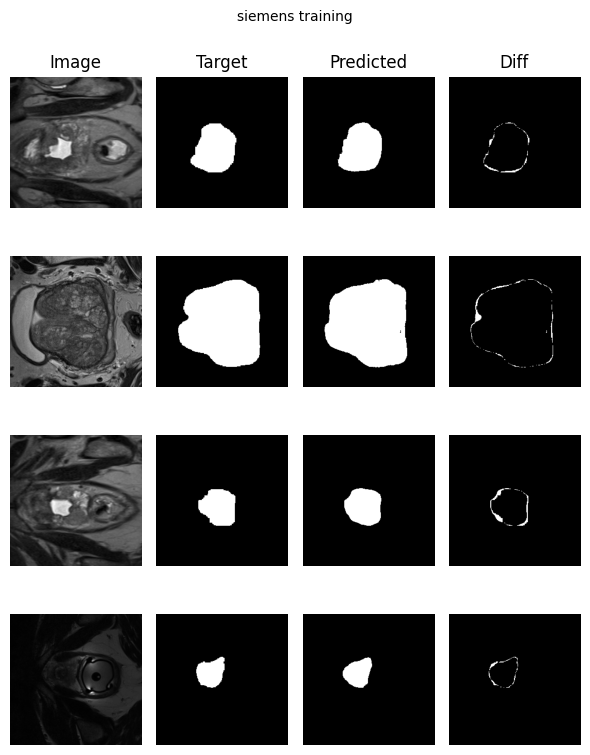

Loading evaluation PMRI dataset for vendor siemens ...


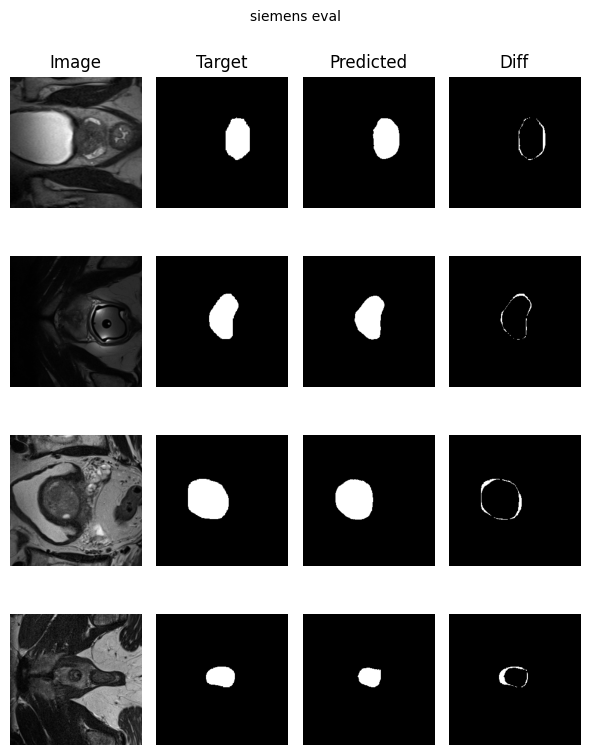

Loading evaluation PMRI dataset for vendor philips ...


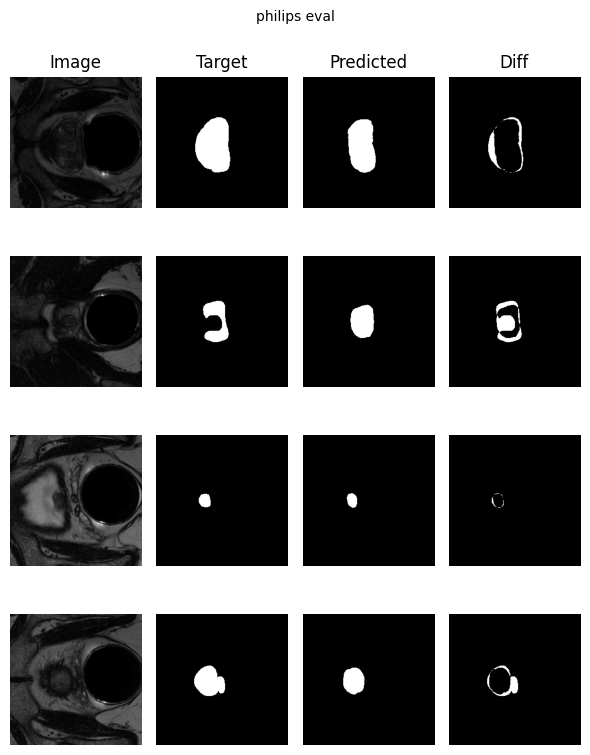

Loading evaluation PMRI dataset for vendor ge ...


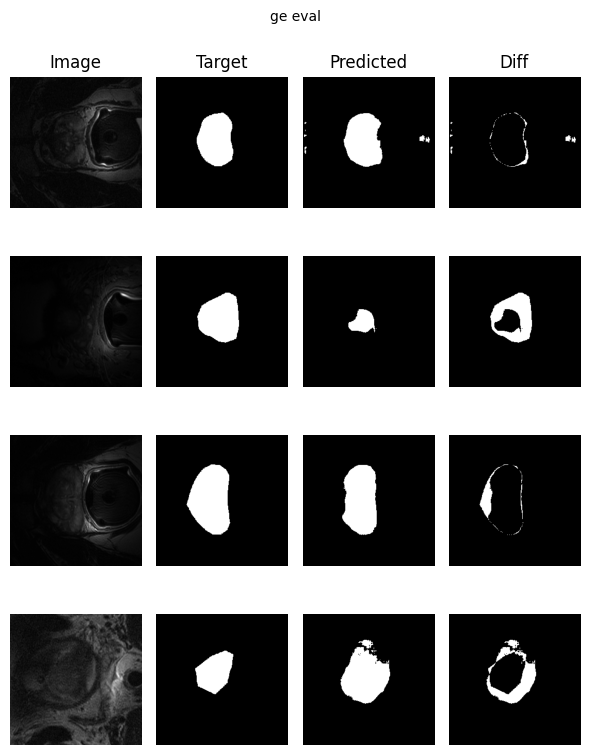

In [9]:
swinunet, state_dict  = get_unet(cfg, return_state_dict=True)
swinunet.eval();
swinunet.to(device);
metrics = {}
for vendor in train_vendors:
    cfg.unet[DATA_KEY].training.subset = 'training'
    cfg.unet[DATA_KEY].training.vendor = vendor
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    plot_batch(data['eval'], swinunet, num_images=4, title=f'{vendor} training')
    metrics[f'{vendor}_train'] = eval_set(cfg, swinunet, data['eval'])
for vendor in test_vendors:
    cfg.unet[DATA_KEY].training.subset = 'validation' if vendor in train_vendors else False 
    cfg.unet[DATA_KEY].training.vendor = vendor
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    plot_batch(data['eval'], swinunet, num_images=4, title=f'{vendor} eval')
    metrics[f'{vendor}_eval'] = eval_set(cfg, swinunet, data['eval'])

In [10]:
metrics

{'siemens_train': {'Dice Score': 0.9585459660323106},
 'siemens_eval': {'Dice Score': 0.9103750970404026},
 'philips_eval': {'Dice Score': 0.791204979022344},
 'ge_eval': {'Dice Score': 0.7025956100430982}}

Loaded model from epoch 40 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt
Loading evaluation PMRI dataset for vendor siemens ...


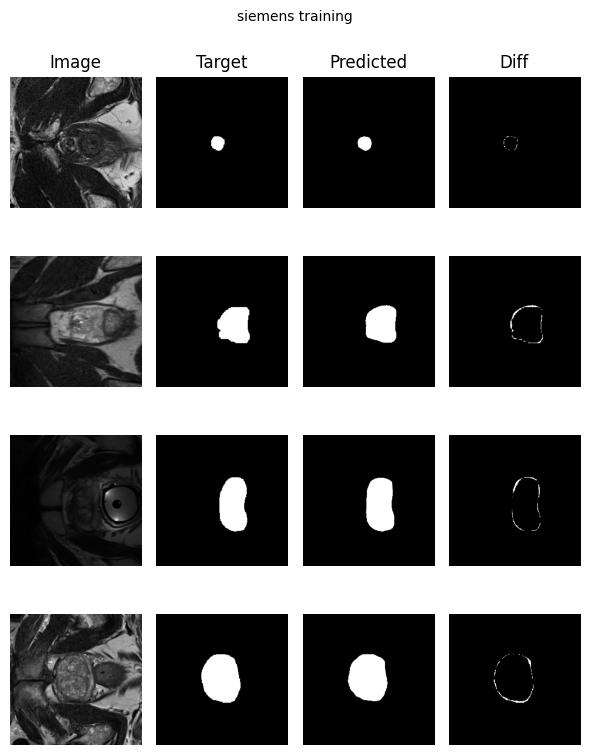

Loading evaluation PMRI dataset for vendor siemens ...


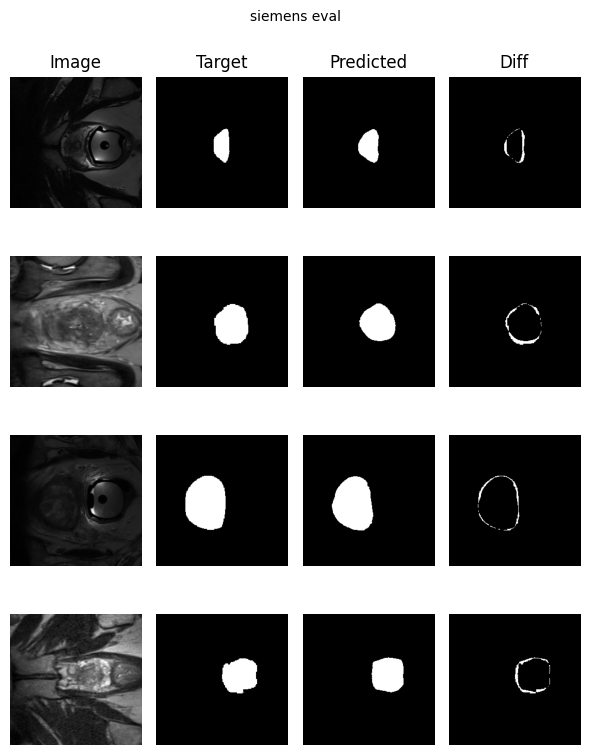

Loading evaluation PMRI dataset for vendor philips ...


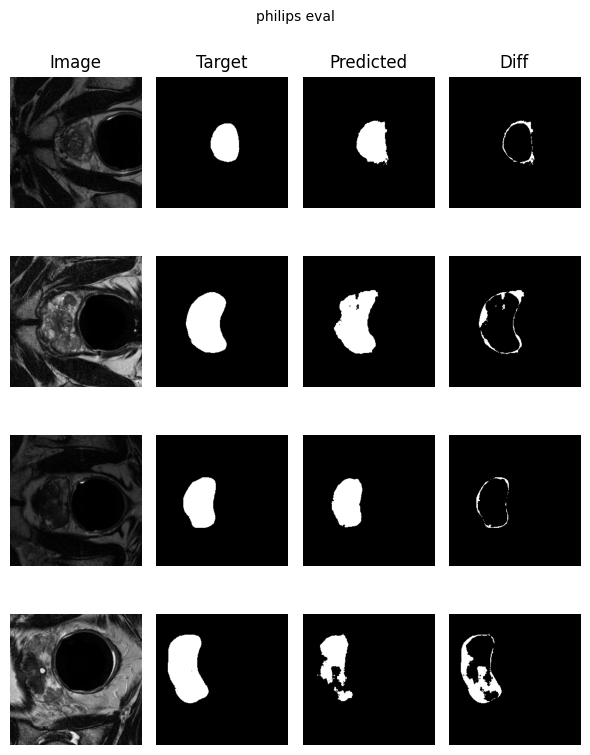

Loading evaluation PMRI dataset for vendor ge ...


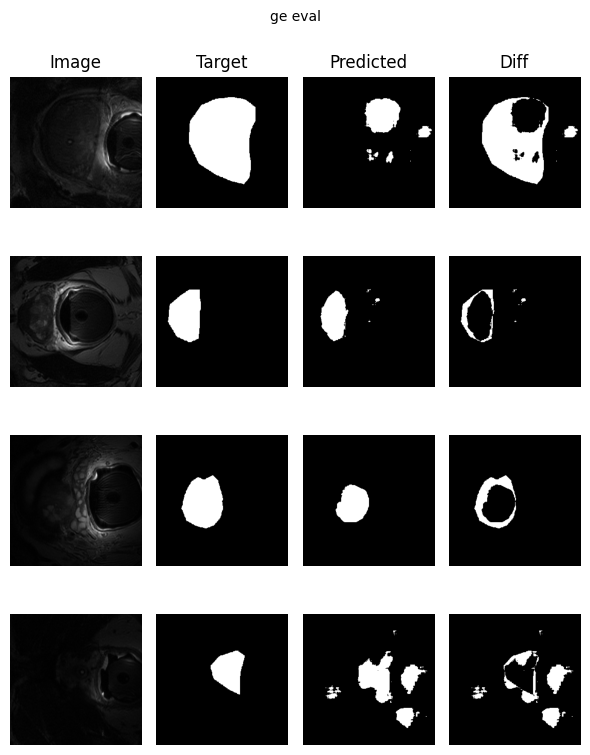

In [12]:
unet, state_dict  = get_unet(cfg, return_state_dict=True)
unet.eval();
unet.to(device);
metrics = {}
for vendor in train_vendors:
    cfg.unet[DATA_KEY].training.subset = 'training'
    cfg.unet[DATA_KEY].training.vendor = vendor
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    plot_batch(data['eval'], unet, num_images=4, title=f'{vendor} training')
    metrics[f'{vendor}_train'] = eval_set(cfg, unet, data['eval'])
for vendor in test_vendors:
    cfg.unet[DATA_KEY].training.subset = 'validation' if vendor in train_vendors else False 
    cfg.unet[DATA_KEY].training.vendor = vendor
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    plot_batch(data['eval'], unet, num_images=4, title=f'{vendor} eval')
    metrics[f'{vendor}_eval'] = eval_set(cfg, unet, data['eval'])

In [13]:
metrics

{'siemens_train': {'Dice Score': 0.958935928755793},
 'siemens_eval': {'Dice Score': 0.904830043598757},
 'philips_eval': {'Dice Score': 0.7749601503213247},
 'ge_eval': {'Dice Score': 0.6063559719885903}}